# Sensor Daisy Chain
This tutorial will analyze a string of sensors wired as a daisy chain where the string is powered from one end. This configuration is common in e.g. instrumentation of production lines, seismic acquisitions systems etc.

The system consists of the following components:
  * A main acquisition unit, powered from a 14.4V Li-ion battery. A voltage booster powers the daisy chain with 48V.
  * 16 sensor units, spaced 16m apart and connected with twisted pair wire for power. The sensor units consume 0.35W from 3.3V. The power input is polarity protected with a diode. A power switch enables power to the next unit. 

In [1]:
# This cell can be removed, it is only used for running the notebook during Sphinx documentation build.
import sys, os
if os.getcwd().replace('\\', '/').endswith("/docs/nb"):
    sys.path.insert(0, os.path.abspath(os.path.join("../../src")))

In [2]:
from sysloss.components import *
from sysloss.system import System
import pandas as pd
import matplotlib.pyplot as plt

## System definition
The system is defined using the System class. 

```{tip}
When you want to analyze a system with variations on specific parameters, it can be very effective to define the system in a function, with target parameters as function arguments. 
```

Since we have 16 identical units, it is practical to use a loop to add the components. Wire resistance depends on wire gauge, and we define that as a parameter to the *create_sys()* function below. 

```{note}
Component names must be unique in the system. Use e.g. an index added to the name.
```

In [3]:
def create_sys(wire_res=4.3, vdrop=0.54, eff=0.72):
    sdc = System("Sensor Daisy chain", Source("Li-ion", vo=14.4, rs=0.2))
    sdc.add_comp("Li-ion", comp=Converter("Boost 48V", vo=48.0, eff=.88))
    parent = "Boost 48V"
    for i in range(1,17,1):
        idx = " [{}]".format(i)
        sdc.add_comp(parent, comp=RLoss("Twisted pair"+idx, rs=wire_res))
        sdc.add_comp("Twisted pair"+idx, comp=VLoss("Diode"+idx, vdrop=vdrop))
        sdc.add_comp("Diode"+idx, comp=RLoss("Power switch"+idx, rs=0.03))
        sdc.add_comp("Diode"+idx, comp=Converter("Buck 3.3V"+idx, vo=3.3, eff=eff))
        sdc.add_comp("Buck 3.3V"+idx, comp=PLoad("Sensor unit"+idx, pwr=0.35))
        parent = "Power switch"+idx
    return sdc

This is a deep power tree (~50 levels), so let's look at the last few nodes only:

In [4]:
sdc = create_sys()
sdc.tree("Twisted pair [12]")

Sensor Daisy chain
└── Twisted pair [12]
    └── Diode [12]
        ├── Buck 3.3V [12]
        │   └── Sensor unit [12]
        └── Power switch [12]
            └── Twisted pair [13]
                └── Diode [13]
                    ├── Buck 3.3V [13]
                    │   └── Sensor unit [13]
                    └── Power switch [13]
                        └── Twisted pair [14]
                            └── Diode [14]
                                ├── Buck 3.3V [14]
                                │   └── Sensor unit [14]
                                └── Power switch [14]
                                    └── Twisted pair [15]
                                        └── Diode [15]
                                            ├── Buck 3.3V [15]
                                            │   └── Sensor unit [15]
                                            └── Power switch [15]
                                                └── Twisted pair [16]
                                                    └── Diode [16]
                                                        ├── Buck 3.3V [16]
                                                        │   └── Sensor unit [16]
                                                        └── Power switch [16]

## Analysis
In the analysis phase we will check the power efficiency of the daisy chain with different wire gauges. Note that current runs both directions on the power pair, so effective resistance is twice that of a single wire.
|Wire gauge|Resistance (ohm/m)|
|----------:|------------------:|
| 20 | 0.0333|
| 22 | 0.053 |
| 24 | 0.084 |
| 26 | 0.134 |
| 28 | 0.213 |

```{tip}
Use the *tags* argument of the *.solve()* function to tag the results table with custom columns.
```

In [5]:
wlen = 16 * 2 # total wire length between sensor nodes
wirelist = {"AWG20": wlen*0.0333, "AWG22": wlen*0.053, "AWG24": wlen*0.084, "AWG26": wlen*0.134, "AWG28": wlen*0.213}
res = []
for wire in wirelist.keys():
    sdc = create_sys(wire_res=wirelist[wire])
    res += [sdc.solve(tags={"Wire":wire})]
df = pd.concat(res, ignore_index=True)
df

,Component,Type,Parent,Domain,Wire,Vin (V),Vout (V),Iin (A),Iout (A),Power (W),Loss (W),Efficiency (%),Warnings
0,Li-ion,SOURCE,,Li-ion,AWG20,14.4,14.258269,0.708653,0.708653,10.204608,0.100438,99.015759,
1,Boost 48V,CONVERTER,Li-ion,Li-ion,AWG20,14.258269,48.0,0.708653,0.185243,10.10417,1.2125,88.0,
2,Twisted pair [1],SLOSS,Boost 48V,Li-ion,AWG20,48.0,47.802605,0.185243,0.185243,8.89167,0.036566,99.58876,
3,Diode [1],SLOSS,Twisted pair [1],Li-ion,AWG20,47.802605,47.262605,0.185243,0.185243,8.855109,0.100031,98.870354,
4,Buck 3.3V [1],CONVERTER,Diode [1],Li-ion,AWG20,47.262605,3.3,0.010285,0.106061,0.486111,0.136111,72.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,Diode [16],SLOSS,Twisted pair [16],Li-ion,AWG28,23.700235,23.160236,0.020989,0.020989,0.497445,0.011334,97.721542,
411,Buck 3.3V [16],CONVERTER,Diode [16],Li-ion,AWG28,23.160236,3.3,0.020989,0.106061,0.486111,0.136111,72.0,
412,Sensor unit [16],LOAD,Buck 3.3V [16],Li-ion,AWG28,3.3,0.0,0.106061,0.0,0.35,0.0,100.0,
413,Power switch [16],SLOSS,Diode [16],Li-ion,AWG28,23.160236,23.160236,0.0,0.0,0.0,0.0,100.0,


The results table is now quite large - let's look at the System total only:

In [6]:
df[df.Component == "System total"][["Component", "Wire", "Power (W)", "Loss (W)", "Efficiency (%)"]].style.hide(axis='index')

Component,Wire,Power (W),Loss (W),Efficiency (%)
System total,AWG20,10.204608,4.604640,54.876857
System total,AWG22,10.403133,4.803176,53.829530
System total,AWG24,10.758709,5.158768,52.050311
System total,AWG26,11.497038,5.897114,48.707534
System total,AWG28,13.815579,8.215690,40.533147


From the first table we can see that the output voltage from the last sensor node is 23.16V. Feeling optimistic - will it work with AWG30 also?

In [7]:
sdc = create_sys(wire_res=16*2*0.338)
sdc.solve()

ValueError: Unstable system: RLoss component 'Twisted pair [14]' has zero output voltage

*.solve()* now throws an exception: The input voltage to sensor node 14 drops to zero. There is no steady-state solution for this system, so AWG30 is not an option. It would work with 13 sensor nodes, however.

Finally, let's plot the voltage along the daisy chain for the different wire gauges.

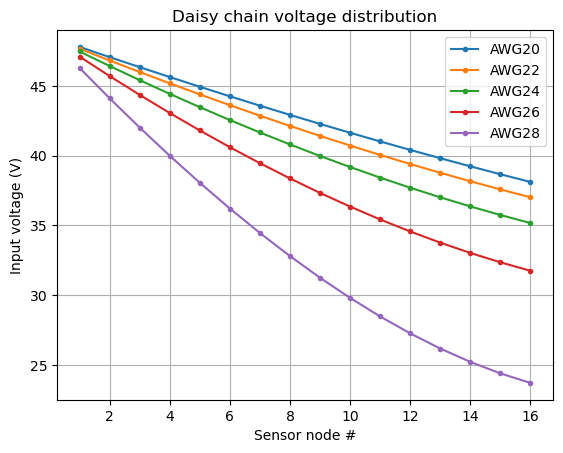

In [8]:
for i in range(0,9,2):
    plt.plot(range(1,17,1), df[(df.Component.str.startswith("Diode")) & (df.Wire=="AWG2"+str(i))][["Vin (V)"]].values, marker='.', label="AWG2"+str(i))
plt.legend()
plt.xlabel("Sensor node #")
plt.ylabel("Input voltage (V)")
plt.grid()
plt.title("Daisy chain voltage distribution");

## Improve accuracy with parameter interpolation
Both current and voltage drop significantly along the daisy chain. The input voltage affects the 3.3V buck converter efficiency, and the current affects the diode forward voltage drop. Next, we define interpolation data for the diode voltage drop and converter efficiency, both as a factor of output current. The data points are extracted from the component's data sheet.

In [9]:
diode_vdrop = {"vi": [48], "io":[1e-3, 1e-2, 0.1, 1, 5], "vdrop":[[.25, .325, 0.4, 0.65, 1.1]]}
buck_eff = {"vi": [48, 36, 24, 12], "io": [1e-3, 10e-3, 0.1, 0.2, 0.3], 
            "eff":[[0.61,0.63,0.66,0.68,0.69],[0.63,0.65,0.68,0.705,0.72],[0.66,.68,0.72,0.73,0.74],[0.7,0.72,0.76,0.78,0.77]]}

In [10]:
res = []
for wire in wirelist.keys():
    sdc = create_sys(wire_res=wirelist[wire], vdrop=diode_vdrop, eff=buck_eff)
    res += [sdc.solve(tags={"Wire":wire})]
df = pd.concat(res, ignore_index=True)
df[df.Component == "System total"][["Component", "Wire", "Power (W)", "Loss (W)", "Efficiency (%)"]].style.hide(axis='index')

Component,Wire,Power (W),Loss (W),Efficiency (%)
System total,AWG20,10.677569,5.077636,52.445766
System total,AWG22,10.862616,5.262711,51.552088
System total,AWG24,11.191970,5.592065,50.035030
System total,AWG26,11.843328,6.243451,47.282970
System total,AWG28,13.532222,7.932379,41.381551


Let's look at the converter efficiency and diode power loss as a function of wire gauge:

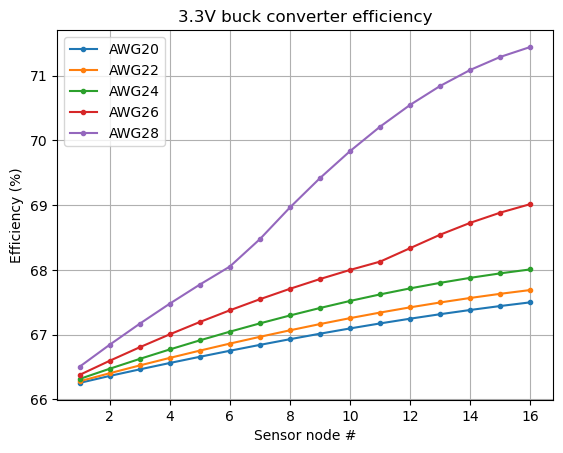

In [11]:
for i in range(0,9,2):
    plt.plot(range(1,17,1), df[(df.Component.str.startswith("Buck")) & (df.Wire=="AWG2"+str(i))][["Efficiency (%)"]].values, marker='.', label="AWG2"+str(i))
plt.legend()
plt.xlabel("Sensor node #")
plt.ylabel("Efficiency (%)")
plt.grid()
plt.title("3.3V buck converter efficiency");

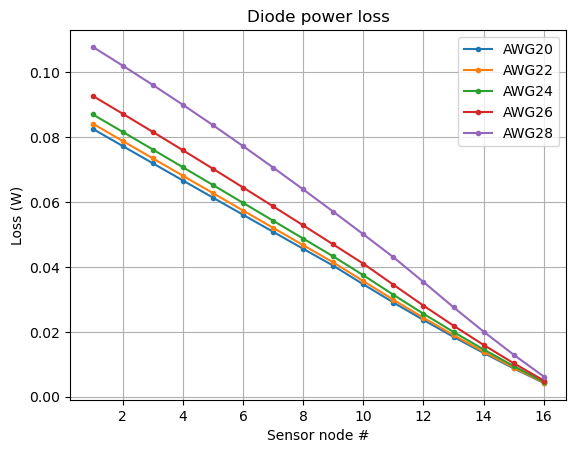

In [12]:
for i in range(0,9,2):
    plt.plot(range(1,17,1), df[(df.Component.str.startswith("Diode")) & (df.Wire=="AWG2"+str(i))][["Loss (W)"]].values, marker='.', label="AWG2"+str(i))
plt.legend()
plt.xlabel("Sensor node #")
plt.ylabel("Loss (W)")
plt.grid()
plt.title("Diode power loss");

```{tip}
Double-check interpolation data by using the *plot_interp()* method. 2D data can be plotted as either a 2D color map or 3D surface, with or without input data marked. Interpolation outside of the input data points is using the last valid data point as value.
```

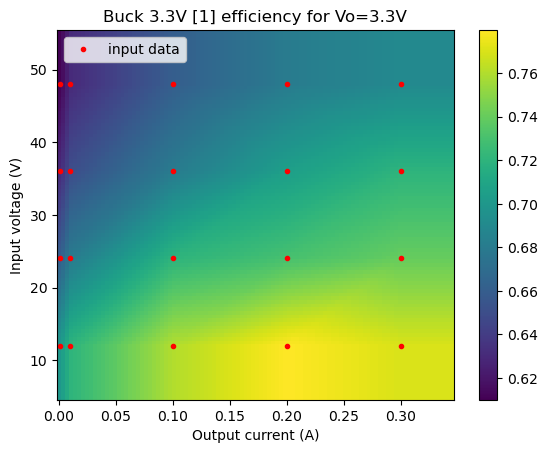

In [13]:
sdc.plot_interp("Buck 3.3V [1]");

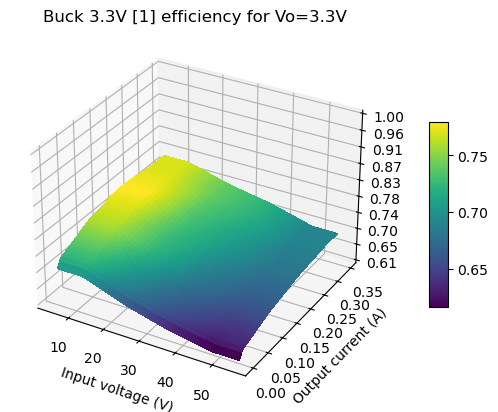

In [14]:
sdc.plot_interp("Buck 3.3V [1]", inpdata=False, plot3d=True);

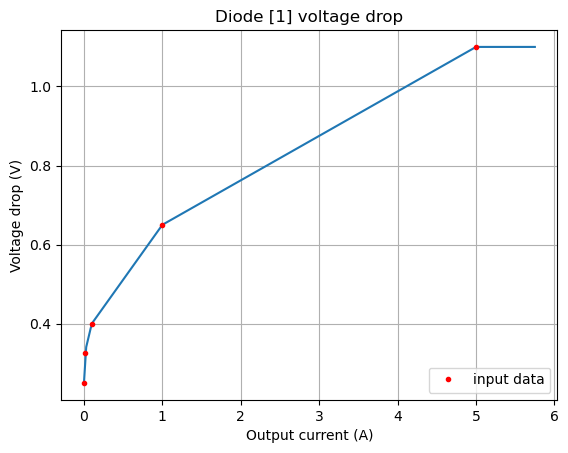

In [15]:
sdc.plot_interp("Diode [1]");

## Summary
This notebook demonstrates how defining a system creation function helps explore system parameters. Further on 2D parameter interpolation is used to define converter efficiency as a function of both input voltage and output current.